<a href="https://colab.research.google.com/github/xvhhvx/5900v_test1/blob/main/mnist_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download the training dataset
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download the test dataset
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create dataloader
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Get device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define module
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 2.304811  [   64/60000]
loss: 2.295809  [ 6464/60000]
loss: 2.290893  [12864/60000]
loss: 2.284280  [19264/60000]
loss: 2.284964  [25664/60000]
loss: 2.278171  [32064/60000]
loss: 2.270249  [38464/60000]
loss: 2.278897  [44864/60000]
loss: 2.266457  [51264/60000]
loss: 2.257609  [57664/60000]
Test Error: 
 Accuracy: 49.4%, Avg loss: 2.256831 

Epoch 2
-------------------------------
loss: 2.259350  [   64/60000]
loss: 2.247834  [ 6464/60000]
loss: 2.250771  [12864/60000]
loss: 2.225234  [19264/60000]
loss: 2.235017  [2

Using KNN


In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from sklearn.metrics import accuracy_score

# Step 1: Load the MNIST dataset with DataLoader
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download the test dataset
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create DataLoader for training and testing with batch size of 64
train_loader = DataLoader(training_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Prepare training data
X_train = []
y_train = []

# Iterate through the training DataLoader to collect data
for images, labels in train_loader:
    X_train.append(images.numpy())
    y_train.append(labels.numpy())

# Concatenate the batches into a single array
X_train = np.concatenate(X_train).reshape(-1, 28*28)  # Flatten the images
y_train = np.concatenate(y_train)

# Prepare test data
X_test = []
y_test = []

# Iterate through the testing DataLoader to collect data
for images, labels in test_loader:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())

# Concatenate the batches into a single array
X_test = np.concatenate(X_test).reshape(-1, 28*28)  # Flatten the images
y_test = np.concatenate(y_test)

# Step 2: Implement KNN using scikit-learn
def sad_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

accuracies = []
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k, metric=sad_distance)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f'Accuracy for K={k}: {accuracy * 100:.2f}%')

# Step 5: Plot accuracy vs K
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), [acc * 100 for acc in accuracies], marker='o')
plt.title('Accuracy vs. K')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 110635785.63it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 38975448.46it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 87949277.00it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4996204.76it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Accuracy with 4 neurons: 86.37%
Accuracy with 8 neurons: 91.89%
Accuracy with 16 neurons: 95.36%
Accuracy with 32 neurons: 96.79%
Accuracy with 64 neurons: 97.36%
Accuracy with 128 neurons: 97.81%
Accuracy with 256 neurons: 97.79%


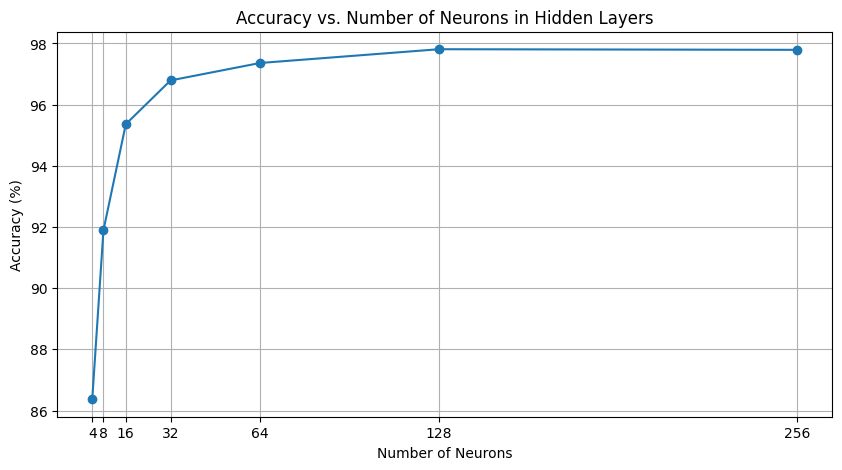

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Step 1: Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Step 2: Define the MLP Model
class MLP(nn.Module):
    def __init__(self, hidden_neurons):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, hidden_neurons)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_neurons, hidden_neurons)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_neurons, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Step 3: Train the Model and Evaluate Accuracy
def train_and_evaluate(hidden_neurons):
    model = MLP(hidden_neurons)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    model.train()
    for epoch in range(20):  # Train for 20 epochs
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Step 4: Experiment with Different Neurons
neurons_list = [4, 8, 16, 32, 64, 128, 256]
accuracies = []

for neurons in neurons_list:
    accuracy = train_and_evaluate(neurons)
    accuracies.append(accuracy)
    print(f'Accuracy with {neurons} neurons: {accuracy * 100:.2f}%')

# Step 5: Plot Accuracy vs. Number of Neurons
plt.figure(figsize=(10, 5))
plt.plot(neurons_list, [acc * 100 for acc in accuracies], marker='o')
plt.title('Accuracy vs. Number of Neurons in Hidden Layers')
plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy (%)')
plt.xticks(neurons_list)
plt.grid()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Step 1: Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Step 2: Define the LeNet-5 Model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # Input: 1 channel, Output: 6 channels
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Average pooling
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # Input: 6 channels, Output: 16 channels
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Fully connected layer
        self.fc2 = nn.Linear(120, 84)  # Fully connected layer
        self.fc3 = nn.Linear(84, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Convolution + ReLU + Pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Convolution + ReLU + Pooling
        x = x.view(-1, 16 * 4 * 4)  # Flatten the tensor
        x = torch.relu(self.fc1(x))  # Fully connected layer + ReLU
        x = torch.relu(self.fc2(x))  # Fully connected layer + ReLU
        x = self.fc3(x)  # Output layer
        return x

# Step 3: Train the Model and Evaluate Accuracy
def train_and_evaluate():
    model = LeNet5()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    model.train()
    for epoch in range(20):  # Train for 20 epochs
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Step 4: Run the training and evaluation
accuracy = train_and_evaluate()
print(f'Accuracy of the LeNet-5 model: {accuracy * 100:.2f}%')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Step 1: Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Step 2: Define the CAN Model
class CAN(nn.Module):
    def __init__(self):
        super(CAN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, dilation=1, padding=1)  # 3x3 conv, dilation=1
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, dilation=2, padding=2)  # 3x3 conv, dilation=2
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, dilation=4, padding=4)  # 3x3 conv, dilation=4
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, dilation=8, padding=8)  # 3x3 conv, dilation=8
        self.conv5 = nn.Conv2d(32, 10, kernel_size=3, dilation=1, padding=1)  # 3x3 conv, dilation=1, output 10 channels
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        self.fc = nn.Linear(10, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = torch.leaky_relu(self.conv1(x))  # Leaky ReLU activation
        x = torch.leaky_relu(self.conv2(x))  # Leaky ReLU activation
        x = torch.leaky_relu(self.conv3(x))  # Leaky ReLU activation
        x = torch.leaky_relu(self.conv4(x))  # Leaky ReLU activation
        x = torch.leaky_relu(self.conv5(x))  # Leaky ReLU activation
        x = self.pool(x)  # Global average pooling
        x = x.view(-1, 10)  # Flatten the tensor to 10 channels
        x = self.fc(x)  # Output layer
        return x

# Step 3: Train the Model and Evaluate Accuracy
def train_and_evaluate():
    model = CAN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    model.train()
    for epoch in range(20):  # Train for 20 epochs
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Step 4: Run the training and evaluation
accuracy = train_and_evaluate()
print(f'Accuracy of the CAN model: {accuracy * 100:.2f}%')